<a href="https://colab.research.google.com/github/BenUCL/Reef-acoustics-and-AI/blob/main/Code/Random_forests_pretrained_CNN_Poly_site.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Random forest classifiers**
This script splits the data into the same train/val/test sets as used for the pretrained CNN and trained CNN. It then trains on the training data and generates the accuracy for the validation data 50 times. The best performing model of the 50 repeats is used to inference on the test data and this accuracy is reported. This proces is repeated 32 times to generate an accuracyfor all train/val/test split combinations. A confusion matrix of all these is then generated.

For polynesia site level classfication I take 1/4 days from each of the 8 sites at random as the val and test set. Every minute from this day is put in the test and every other in the val. So each of the test and val have recordings from all 8 sites. If i put 4 enitre sites in the val, and 4 in the test, then it would train to fit the val well, and do crap on the test.

In [1]:
# Connect Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#imports
import sklearn
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
import pandas as pd
from sklearn.model_selection import train_test_split
import statistics

import collections
import numpy
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

import csv 

In [3]:
# Upload the csv of features and copy the path
path = r'/content/drive/MyDrive/Reef soundscapes with AI/Results/full_dataset_features/pretrained_CNN_poly.csv'
num_classes = 8
labels = ['SiteA', 'SiteB', 'SiteC', 'SiteD', 'SiteW', 'SiteX', 'SiteY', 'SiteZ']

In [4]:
data = pd.read_csv (path) #load dataframe
temp_df = data.reset_index() #put index in order
temp_df = temp_df.iloc[: , 2:] #remove unnecessary index
temp_df = temp_df.T #transpose to match indices format
temp_df = temp_df.reset_index() #re-add the index
df = temp_df.rename(columns={"index": "minute"})

df

,minute,0,1,2,3,4,5,6,7,8,...,118,119,120,121,122,123,124,125,126,127
0,SiteCDay3.805322778.210303214058.wav,0.024271,0.015441,0.673868,0.015810,0.000000,0.0,0.0,0.013191,0.0,...,0.0,0.075812,0.079045,0.000000,0.164519,0.160550,0.027020,0.000000,0.000133,0.001901
1,SiteXDay3.5210.210215103530.wav,0.024545,0.001385,0.885764,0.007736,0.000000,0.0,0.0,0.003682,0.0,...,0.0,0.054833,0.031658,0.000000,0.210327,0.050721,0.043802,0.000000,0.000000,0.000000
2,SiteYDay2.5210.210302223537.wav,0.038698,0.000000,0.621418,0.045740,0.000000,0.0,0.0,0.029869,0.0,...,0.0,0.042964,0.068022,0.000000,0.006417,0.156122,0.001582,0.000000,0.000000,0.000000
3,SiteDDay2.5210.210317091056.wav,0.011494,0.099208,0.532689,0.007028,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.006671,0.003732,0.000000,0.039698,0.226014,0.066506,0.000000,0.001176,0.000000
4,SiteADay3.805322778.210205190014.wav,0.000000,0.084872,0.072530,0.075937,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.023012,0.000000,0.000000,0.237829,0.050223,0.057576,0.000000,0.000000,0.008781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8971,SiteDDay3.5210.210317141559.wav,0.011558,0.052947,0.591418,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.007208,0.003910,0.000000,0.030538,0.202830,0.018578,0.000000,0.000000,0.000000
8972,SiteBDay2.805322778.210214103515.wav,0.001393,0.066229,0.398799,0.149027,0.000000,0.0,0.0,0.000777,0.0,...,0.0,0.053009,0.007668,0.000623,0.001218,0.297432,0.215393,0.000000,0.000000,0.000000
8973,SiteZDay1.805322778.210315152558.wav,0.020564,0.101476,0.334346,0.159136,0.000654,0.0,0.0,0.016787,0.0,...,0.0,0.068794,0.025673,0.000000,0.000000,0.264537,0.285786,0.011261,0.000000,0.000525
8974,SiteADay3.805322778.210206002517.wav,0.000000,0.199585,0.116687,0.252471,0.000000,0.0,0.0,0.000073,0.0,...,0.0,0.000000,0.000000,0.000000,0.028089,0.093403,0.154533,0.000000,0.000076,0.006282


In [5]:
'''This code block find the unique identifiers of each deployment (i.e what
hour of the day at what site) and splits these ID's into training, val and
test sets. These are used in the next codeblock to select the actual 
recordings using these ID's which are present within each minute from the
same deployment'''



#This function takes the parts of a filename that make it unique
 #This uses Tims naming convention, specific to the 2018 Indonesia data
def get_identifier(filename):
    #find part of the name that corresponds to the deployment
    t = filename.split(".")[0]                    
    return t #e.g 'deployment2'
 
#Function to get unique values within an array
def unique(list1):
    x = np.array(list1)
    return np.unique(x)

def get_class(filename):
    #find part of the name that corresponds to the site and deployment
     #adapted the get_identifier function above to only get class (e.g healthy)
    class_type = filename.split(".")[0][0:5]
    return class_type #e.g 'SiteH'


def train_test_val_split(df):
  IDs = []
  for index, row in df.iterrows():
      filename = (df['minute'][index])
      IDs.append(get_identifier(filename))
  all_IDs = unique(IDs)  #a list of these, e.g 'SiteHdeployment2' ...

  #Use the above function to get a list of unique deployment ID's (approx 30 for healthy, and again for degraded)
  unshuffled_unique_deployments = unique(all_IDs) #so for the real data this will give a big long order list

  #ensure the same random shuffle is made each time for a CV, so the order is conserved across the 3 methods
  np.random.seed(repeat) 
  #print(repeat)

  #shuffle this list
  shuffled_unique_deployments = np.random.permutation(unshuffled_unique_deployments)


  #Create df of all deployments and their class
  d = {'Deployment': shuffled_unique_deployments }
  d1 = pd.DataFrame(data=d)

  df_withclasses = d1

  # add a column to the DF that contains class
  new_list = []
  for i in range(len(df_withclasses)):
      new_list.append(get_class(df_withclasses['Deployment'][i]))

  df_withclasses.insert(1, 'Class', new_list)

  # Use the new df to split the deployment ID's into train/val/test sets
  # pick 25% (8/32 deployments) of data as val data. test_size will be the proportion that goes into the train/test line below
  # this is stratified, so if there's 8 classes with 4 deployments each, and you pick 25%, then 1deployment from each class will go in the val and test
  train, val_test = sklearn.model_selection.train_test_split(df_withclasses, test_size=0.25, stratify=df_withclasses['Class'])  
  # pick 0.33*0.75% (12/72 deployments) of the_rest to be the test data <- see val_deployments & test_dpeloyments to check
 # train, test = sklearn.model_selection.train_test_split(the_rest, test_size=0.333, stratify=the_rest['Class'])

  # convert these to numpy arrays
  train_deployments = np.array(train['Deployment'])
  val_test_deployments = np.array(val_test['Deployment'])
  #test_deployments = np.array(test['Deployment'])
  np.random.seed() #now lift the seed so that randomisation can be used again in the rest of the script
   
  return train_deployments, val_test_deployments



In [6]:
def put_files_in_splits(train_deployments, val_test_deployments):
  '''This block uses the ID's of the train, val and test sets generated above
  to select the actual recordings. This generates:
  train_files
  val_files
  test_files
  Which are the arrays of recordings corresponding to each of these '''

  #now select all files in dir that have these ID's in their name
  train_files = []
  val_test_files = []

  for index, row in df.iterrows():
    filename = (df['minute'][index]) 
    
    #print(f)
    ID = filename.split(".")[0]
    #print(ID)
    if ID in train_deployments:
      train_files.append(filename)
    if ID in val_test_deployments:
      val_test_files.append(filename)

  return train_files, val_test_files



In [7]:
def get_class(filename):
    #find part of the name that corresponds to the deployment
     #adapted the get_identifier function above to only get class (e.g healthy)
    site = filename[0:5]
    return site
    
df_withclasses = df

# add a column to the DF that contains class
new_list = []
for i in range(len(df_withclasses)):
    new_list.append(get_class(df_withclasses['minute'][i]))

df_withclasses.insert(1, 'Class', new_list)
df_withclasses.head(20)

,minute,Class,0,1,2,3,4,5,6,7,...,118,119,120,121,122,123,124,125,126,127
0,SiteCDay3.805322778.210303214058.wav,SiteC,0.024271,0.015441,0.673868,0.015810,0.000000,0.0,0.000000,0.013191,...,0.000000,0.075812,0.079045,0.000000,0.164519,0.160550,0.027020,0.000000,0.000133,0.001901
1,SiteXDay3.5210.210215103530.wav,SiteX,0.024545,0.001385,0.885764,0.007736,0.000000,0.0,0.000000,0.003682,...,0.000000,0.054833,0.031658,0.000000,0.210327,0.050721,0.043802,0.000000,0.000000,0.000000
2,SiteYDay2.5210.210302223537.wav,SiteY,0.038698,0.000000,0.621418,0.045740,0.000000,0.0,0.000000,0.029869,...,0.000000,0.042964,0.068022,0.000000,0.006417,0.156122,0.001582,0.000000,0.000000,0.000000
3,SiteDDay2.5210.210317091056.wav,SiteD,0.011494,0.099208,0.532689,0.007028,0.000000,0.0,0.000000,0.000000,...,0.000000,0.006671,0.003732,0.000000,0.039698,0.226014,0.066506,0.000000,0.001176,0.000000
4,SiteADay3.805322778.210205190014.wav,SiteA,0.000000,0.084872,0.072530,0.075937,0.000000,0.0,0.000000,0.000000,...,0.000000,0.023012,0.000000,0.000000,0.237829,0.050223,0.057576,0.000000,0.000000,0.008781
5,SiteBDay2.805322778.210213234009.wav,SiteB,0.000000,0.142083,0.234632,0.173689,0.014336,0.0,0.000000,0.038024,...,0.000000,0.012392,0.000000,0.000685,0.000000,0.195165,0.205291,0.000000,0.001270,0.001153
6,SiteZDay3.805322778.210318095537.wav,SiteZ,0.000716,0.108372,0.226563,0.285881,0.000000,0.0,0.000000,0.000000,...,0.000000,0.100699,0.000163,0.000000,0.002466,0.249441,0.215891,0.000000,0.016982,0.000000
7,SiteXDay1.5210.210212133051.wav,SiteX,0.015893,0.004436,0.844774,0.002443,0.000000,0.0,0.000000,0.000553,...,0.000000,0.061659,0.033925,0.000000,0.250106,0.062771,0.033673,0.000000,0.000000,0.000000
8,SiteYDay3.5210.210304051553.wav,SiteY,0.038993,0.000510,0.706550,0.015643,0.000050,0.0,0.000000,0.017464,...,0.000000,0.031731,0.042200,0.000000,0.001565,0.145362,0.000840,0.000000,0.000000,0.000000
9,SiteZDay4.805322778.210319063548.wav,SiteZ,0.028377,0.114053,0.357996,0.244016,0.000095,0.0,0.000000,0.024385,...,0.000000,0.120225,0.022196,0.000000,0.000000,0.264809,0.148454,0.002166,0.000000,0.001076


In [8]:
all_saved_test_accs = []
whole_day_saved_test_accs = []
ConfusionMatrix = np.zeros((num_classes,num_classes), dtype=float)


for i in range(100): #perform 10 different CV splits
  repeat = i+1 
  thisCV_saved_test_accs = []
  thisCV_saved_test_day_accs = []
  for g in range(1): #perform 10 repeats of each CV split - scrapped this as i switched to 100 above
      
      train_df = pd.DataFrame(columns=df_withclasses.columns)
      val_test_df = pd.DataFrame(columns=df_withclasses.columns)
      
      print('Training cross val: ' + str(repeat))
      train_deployments, val_test_deployments = train_test_val_split(df)
      train_files, val_test_files = put_files_in_splits(train_deployments, val_test_deployments)

      for q in range(len(df_withclasses)):
        if df_withclasses['minute'][q] in train_files:
          train_df = train_df.append([df_withclasses.iloc[[q]]])

        if df_withclasses['minute'][q] in val_test_files:
          val_test_df = val_test_df.append([df_withclasses.iloc[[q]]])  

      # now split the val_test stuff into two, so every other recording is in each
      val_df = val_test_df.iloc[::2,:] 
      test_df = val_test_df.iloc[1::2,:]     

      # now create a df for the features and another for the labels
      train_feats = train_df.iloc[:, 2:].to_numpy()
      train_labels = train_df.iloc[:, 1].to_numpy()

      val_feats = val_df.iloc[:, 2:].to_numpy()
      val_labels = val_df.iloc[:, 1].to_numpy()

      test_feats = test_df.iloc[:, 2:].to_numpy()
      test_labels = test_df.iloc[:, 1].to_numpy()

      val_accuracy_score = 0
      for k in range(50):              # Picked 50 as 50 epochs used in NN
        #Training on train data
        model = RandomForestClassifier(n_jobs = -1, random_state=k)
        model.fit(train_feats, train_labels)

        #Inferencing on validation data
        new_val_acc = model.score(val_feats, val_labels)

        #If val acc improved, inference on test data
        if new_val_acc >  val_accuracy_score:
          #save the new high score for val
          val_accuracy_score = new_val_acc 

          #get 1min acc for test data
          test_acc = model.score(test_feats, test_labels) 
          
          #get the acc when using the most common prediction across all minutes in a day for each site
          test_predictions = model.predict(test_feats)

          # get confusion matrix values
          best_ConfusionMatrix = confusion_matrix(test_labels, test_predictions, labels = labels) ###

          acc = 0 
          for i in range(num_classes):
            max = np.amax(best_ConfusionMatrix[i])
            if max == best_ConfusionMatrix[i,i]:
              acc += 1
              whole_day_acc = acc/num_classes
      
      #Save best results
      ConfusionMatrix = np.add(ConfusionMatrix, best_ConfusionMatrix) ###
      thisCV_saved_test_accs.append(test_acc)
      all_saved_test_accs.append(test_acc)
      thisCV_saved_test_day_accs.append(whole_day_acc)
      whole_day_saved_test_accs.append(whole_day_acc)


  print('Accuracies for 1min cross validation split number : '+ str(repeat))
  print(thisCV_saved_test_accs)
  print('Accuracies for whole day cross validation split number : '+ str(repeat))
  print(thisCV_saved_test_day_accs)
  thisCV_saved_test_accs = []
  thisCV_saved_test_day_accs = []


print('Completed RFs:')
print(len(all_saved_test_accs))

def Average(lst):
    return sum(lst) / len(lst)
mean_accuracy = Average(all_saved_test_accs)
stdev = np.std(all_saved_test_accs)

print('1min saved_test_accs: ')
print(all_saved_test_accs)
result = 'Mean accuracy for 1min files with standard deviation = {} (±{})'.format(str(mean_accuracy), str(stdev))
print(result) 



print('Completed RFs:')
print(len(whole_day_saved_test_accs))

def Average(lst):
    return sum(lst) / len(lst)
mean_accuracy = Average(whole_day_saved_test_accs)
stdev = np.std(whole_day_saved_test_accs)

print('Whole day saved_test_accs: ')
print(whole_day_saved_test_accs)
result = 'Mean accuracy for whole days with standard deviation = {} (±{})'.format(str(mean_accuracy), str(stdev))
print(result) 

print()
print(repr(ConfusionMatrix))

Training cross val: 1
Accuracies for 1min cross validation split number : 1
[0.9921602787456446]
Accuracies for whole day cross validation split number : 1
[1.0]
Training cross val: 2
Accuracies for 1min cross validation split number : 2
[0.9956369982547993]
Accuracies for whole day cross validation split number : 2
[1.0]
Completed RFs:
2
1min saved_test_accs: 
[0.9921602787456446, 0.9956369982547993]
Mean accuracy for 1min files with standard deviation = 0.993898638500222 (±0.0017383597545773677)
Completed RFs:
2
Whole day saved_test_accs: 
[1.0, 1.0]
Mean accuracy for whole days with standard deviation = 1.0 (±0.0)

array([[281.,   0.,   0.,   0.,   0.,   1.,   0.,   0.],
       [  2., 284.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0., 283.,   0.,   0.,   0.,   0.,   0.],
       [  2.,   0.,   0., 275.,   0.,   1.,   0.,   1.],
       [  0.,   0.,   0.,   0., 293.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0., 315.,   0.,   0.],
       [  0.,   0.,   0.,   0., 

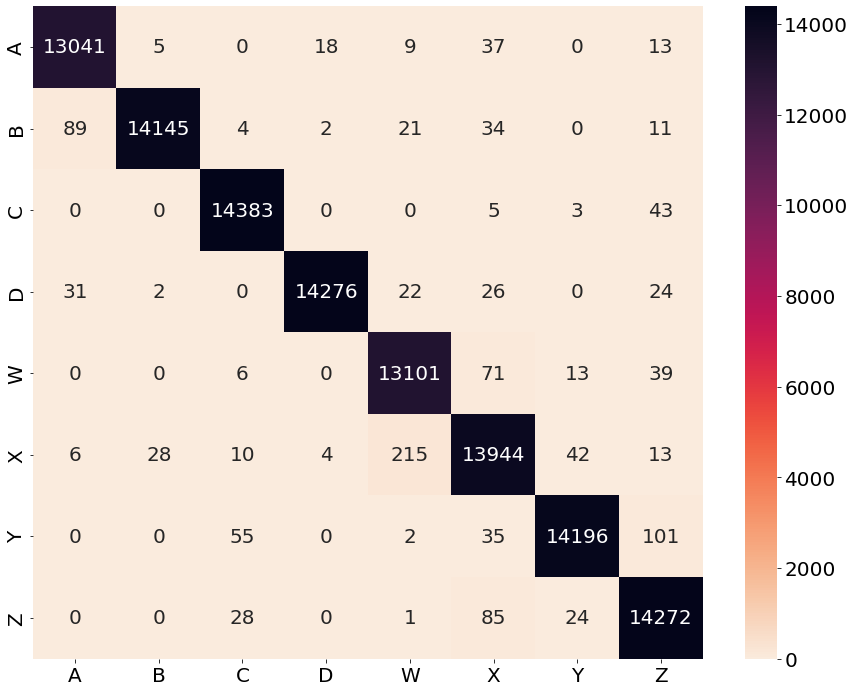

In [9]:
#HPCConfusionMatrix = [[1.3041e+04, 5.0000e+00, 0.0000e+00, 1.8000e+01, 9.0000e+00,
      #   3.7000e+01, 0.0000e+00, 1.3000e+01],
      #  [8.9000e+01, 1.4145e+04, 4.0000e+00, 2.0000e+00, 2.1000e+01,
      #   3.4000e+01, 0.0000e+00, 1.1000e+01],
      #  [0.0000e+00, 0.0000e+00, 1.4383e+04, 0.0000e+00, 0.0000e+00,
      #   5.0000e+00, 3.0000e+00, 4.3000e+01],
      #  [3.1000e+01, 2.0000e+00, 0.0000e+00, 1.4276e+04, 2.2000e+01,
      #   2.6000e+01, 0.0000e+00, 2.4000e+01],
      #  [0.0000e+00, 0.0000e+00, 6.0000e+00, 0.0000e+00, 1.3101e+04,
      #   7.1000e+01, 1.3000e+01, 3.9000e+01],
      #  [6.0000e+00, 2.8000e+01, 1.0000e+01, 4.0000e+00, 2.1500e+02,
      #   1.3944e+04, 4.2000e+01, 1.3000e+01],
      #  [0.0000e+00, 0.0000e+00, 5.5000e+01, 0.0000e+00, 2.0000e+00,
      #   3.5000e+01, 1.4196e+04, 1.0100e+02],
      #  [0.0000e+00, 0.0000e+00, 2.8000e+01, 0.0000e+00, 1.0000e+00,
      #   8.5000e+01, 2.4000e+01, 1.4272e+04]]

array = ConfusionMatrix

df_cm = pd.DataFrame(array, index = [i for i in "ABCDWXYZ"],
                  columns = [i for i in "ABCDWXYZ"])
plt.figure(figsize = (15,12))
cmap = sn.cm.rocket_r
ax = sn.heatmap(df_cm, annot=True, annot_kws={"fontsize":20}, fmt='g', cmap = cmap)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 20)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 20)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)